# Latent Semantic Analysis (LSA)

This notebook is for studying SVD further: will need to project the test data into the same semantic space (see IntroToTextAnalyticsWithR, part 8: "As with TF-IDF, we will need to project new data (e.g., the test data) into the SVD semantic space."

Consulted Prof. Steve Brunton's [YouTube lecture series](https://www.youtube.com/playlist?list=PLMrJAkhIeNNSVjnsviglFoY2nXildDCcv) and [Data-Driven Science and Engineering book](https://www.amazon.com/Data-Driven-Science-Engineering-Learning-Dynamical/dp/1108422098) - a brief summary of relevant parts can be found [here](./Extra_SteveBrunton_SVD_lecture.pdf).

Using sklearn's **TruncatedSVD** class' ARPACK algorithm (seemed a lot faster than the randomized option in the case). Under the hood, this class just uses `scipy.psarse.linalg`:

[(source)](https://github.com/scikit-learn/scikit-learn/blob/0fb307bf3/sklearn/decomposition/_truncated_svd.py#L24)
```
        if self.algorithm == "arpack":
            U, Sigma, VT = svds(X, k=self.n_components, tol=self.tol)
            # svds doesn't abide by scipy.linalg.svd/randomized_svd
            # conventions, so reverse its outputs.
            Sigma = Sigma[::-1]
            U, VT = svd_flip(U[:, ::-1], VT[::-1])
```    

---

**Toy Example**

In [6]:
from scipy.sparse import random as sparse_random
from sklearn.random_projection import sparse_random_matrix

X_example = sparse_random(200, 50, density=0.01, format='csr', random_state=42)

In [7]:
X_example.shape # 200 documents, 50 terms

(200, 50)

In [8]:
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import svd_flip

U, Sigma, VT = svds(X_example.T, # pass a term-document matrix
                    k=5)
Sigma = Sigma[::-1]
U, VT = svd_flip(U[:, ::-1], VT[::-1])

In [9]:
U.shape, Sigma.shape, VT.shape

((50, 5), (5,), (5, 200))

In [10]:
# save to current dir
import pandas as pd
df = pd.DataFrame(X_example.toarray())
df.to_csv("../data/X_example.csv", index=False)

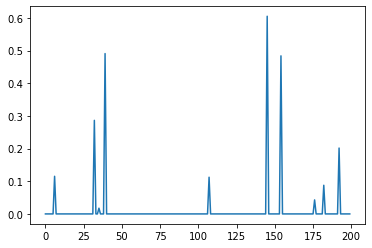

In [13]:
import matplotlib.pyplot as plt 

plt.plot(VT[0])
plt.show()

R code for the same plot:

```
# setup
rm(list=ls())
library(irlba)
wd_ <- "../GitHub/TwitterSentimentAnalysis/data"
if (getwd() != wd_) setwd(wd_)
# read csv
X <- read.csv("X_example.csv")
X <- as.matrix(X)
# svd
svd_ <- irlba(X, nv=5, maxit=10)
# plot
plot(svd_$v[,1], type='l', col='blue', ylab='First Right Singular Vector')
# save plot
dev.copy(png,'../plots/FirstRightSingularVector.png')
dev.off()
```

In [15]:
V = VT.T
V.shape # the new training set of 200 docs, 5 "topics" (components)

(200, 5)

Projecting a new TF-IDF document $d$ into the same semantic space created by the training data SVD requires us to save the $\Sigma$ and $U^T$ values such that we can recreate our $V$ matrix using the following projection: $\hat{d} = \Sigma^{-1}U^Td$

In [16]:
Sigma_inv = 1 / Sigma

In [19]:
print(V[1])

[-2.04043685e-18 -1.45839974e-18 -1.95396780e-18 -5.05428100e-18
  9.13917596e-19]


In [21]:
Sigma_inv.shape, U.T.shape, V[1].shape

((5,), (5, 50), (5,))

In [22]:
import numpy as np

sigma_dot_ut = np.dot(Sigma_inv, U.T)

In [23]:
sigma_dot_ut.shape

(50,)

In [43]:
np.dot(np.array([sigma_dot_ut]).T, np.array([V[1]])).shape

(50, 5)

In [40]:
np.array([V[1]]).shape

(1, 5)

In [10]:
import numpy as np
first_term = np.dot(sigma_inv, U.T)

In [11]:
np.array([first_term]).T.shape

(200, 1)

In [12]:
doc.shape

(1, 50)

In [13]:
doc_hat = np.matmul(np.array([first_term]).T, doc)

In [14]:
doc_hat.shape

(200, 50)

In [15]:
doc_hat[1]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.79675347e-18,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])

In [16]:
VT[1]

array([-1.74095525e-16,  2.68743109e-17,  6.28080937e-17, -3.98815411e-17,
       -1.39307519e-17, -1.96455737e-17,  5.57490577e-17, -1.49122997e-17,
       -2.26357690e-17, -2.23013095e-17, -9.42166284e-17, -1.24172748e-16,
       -2.03548105e-16,  1.18525394e-16,  2.11109649e-01, -5.81359539e-16,
        8.47285275e-17, -2.99125065e-17,  3.88166712e-01,  9.56811857e-18,
       -5.68480776e-17,  3.37740663e-17,  3.20771924e-17, -3.57994597e-17,
       -4.59814368e-16,  2.86783142e-17,  2.26306789e-01, -1.13587700e-16,
       -4.56050968e-17, -9.51796856e-17, -3.92624489e-17, -5.39865564e-17,
       -6.17355162e-18, -1.55843641e-16, -6.90041151e-17,  3.65476654e-17,
       -8.38926778e-18, -2.39928929e-15,  5.40425021e-17,  4.22669829e-17,
        8.68069442e-01,  5.15361502e-17, -9.36068455e-19,  3.13520262e-17,
       -1.07678039e-16, -8.02449149e-17, -8.66688149e-18, -2.27379818e-17,
        7.94321153e-17,  2.50451876e-17])

In [17]:
# As with TF-IDF, we will need to project new data (e.g., the test data)
# into the SVD semantic space. The following code illustrates how to do
# this using a row of the training data that has already been transformed
# by TF-IDF.

#sigma.inverse <- 1 / train.irlba$d
#sigma_inv = 1 / svd_model.singular_values_

#u.transpose <- t(train.irlba$u)


#document <- train.tokens.tfidf[1,]

#document_hat <- sigma_inv * Ut %*% document

# Look at the first 10 components of projected document and the corresponding
# row in our document semantic space (i.e., the V matrix)
#document.hat[1:10]
#train.irlba$v[1, 1:10]


#
# Create new feature data frame using our document semantic space of 300
# features (i.e., the V matrix from our SVD).
#
#train.svd <- data.frame(Label = train$Label, train.irlba$v)
